In [45]:
import os
cwd = os.getcwd().replace("\\", "/")
print(cwd)

c:/Users/Timothe/Documents/eth4/cil/github/CIL/models/segformer


In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation


BATCH_SIZE = 1

kaggle = True if cwd == "/kaggle/working" else False

if kaggle:
    data_path = "/kaggle/input/"
    main_path = data_path+"ethz-cil-road-segmentation-2023/"
    pretrain_path = data_path+"massachusetts-roads-dataset/"
else:
    data_path = cwd + "/../../data/"
    main_path = data_path+"official_roads/"
    pretrain_path = data_path+"massachusetts_roads/"

main_x_path = main_path + "training/images/"
main_y_path =  main_path + "training/groundtruth/"

pretrain_x_path =  pretrain_path + "tiff/train/"
pretrain_y_path =  pretrain_path + "tiff/train_labels/"

def save(model):
    if kaggle:
        torch.save(model.state_dict(), "/kaggle/working/segformer.pth")
    else:
        torch.save(model.state_dict(), "segformer.pth")

def load(model):
    if kaggle:
        model.load_state_dict(torch.load("/kaggle/working/segformer.pth"))
    else:
        model.load_state_dict(torch.load("segformer.pth"))

In [47]:
# Load the model and setup the classifier head for binary classification
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model.decode_head.classifier = nn.Conv2d(768, 1, kernel_size=(1, 1), stride=(1, 1))
model = model.cuda()

# Instantiate the feature extractor
feature_extractor:SegformerImageProcessor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640", size=800)

# Do a forward pass with random data to initialize the model
# x = torch.randn(1, 3, 800, 800).cuda()
# y = model(x).logits
# print(y.shape)


print("model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameters: 84594113


c:\ProgramData\Anaconda3\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [48]:
class CustomDataset(Dataset):
    def __init__(self, x_path, y_path):
        self.x_path = x_path
        self.y_path = y_path
        self.image_files = os.listdir(x_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        name = self.image_files[idx]

        x_orig:Image = Image.open(self.x_path + name).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)/255
        x = feature_extractor(images=x_orig, return_tensors="pt").pixel_values.squeeze(0).cuda()

        y_orig:Image = Image.open(self.y_path + name.replace(".tiff", ".tif")).convert("RGB")
        #if the image is larger than 400x400, downscale it
        if y_orig.size[0] > 400 or y_orig.size[1] > 400:
            y_orig = y_orig.resize((400, 400))
        y_orig = np.array(y_orig, dtype=np.float32)/255
        y = torch.tensor(y_orig, dtype=torch.float32)
        y = y[:, :, 0]
        y = y.unsqueeze(0).cuda()

        return x, y, name, x_orig, y_orig


In [49]:
pretrain_dataset = CustomDataset(pretrain_x_path, pretrain_y_path)

pretrain_loader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
main_dataset = CustomDataset(main_x_path, main_y_path)

# Split the dataset
val_size = int(len(main_dataset) * 0.2)
train_size = len(main_dataset) - val_size
train_dataset, val_dataset = random_split(main_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [51]:
def visualize_sample(model, loader):
    with torch.no_grad():
        rows = 2
        fig, ax = plt.subplots(rows, 3, figsize=(20, 30))
        for i, (x, y, name, x_orig, y_orig) in enumerate(loader):
            x = x[0]
            y = y[0]
            name = name[0]
            x_orig = x_orig[0]
            y_orig = y_orig[0]

            print(name)

            # print(pred.shape)
            # print(y.shape)
            # print(x.shape)

            pred = model(x.unsqueeze(0)).logits.squeeze(0)
            # print(pred.shape)

            pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
            y = y.permute(1, 2, 0).cpu().numpy()
            x = x.permute(1, 2, 0).cpu().numpy()

            # print(pred.shape)
            # print(y.shape)
            # print(x.shape)

            # print(pred)
            # print(y)
            # print(x)

            ax[i][0].imshow(x_orig)
            ax[i][1].imshow(pred, cmap='gray')
            ax[i][2].imshow(y, cmap='gray')

            if i == rows - 1:
                break


In [52]:
# visualize_sample(model, pretrain_loader)

In [53]:
# visualize_sample(model, val_loader)

In [54]:
# Set up training
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [55]:
use_wandb = False

def train(model, dataset, optimizer):
    model.train()
    total_loss = 0
    for x, y, _a, _b, _c in tqdm(dataset):
        x, y = x.cuda(), y.cuda()     
        optimizer.zero_grad()
        y_pred = model(x).logits
        y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})

In [56]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([])
    y_gt = np.array([])
    with torch.no_grad():
        for x, y, _a, _b, _c in dataset:
            x, y = x.cuda(), y.cuda()  
            # print(x.shape , y.shape)
            y_pred = model(x).logits
            y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
            y_pred = torch.sigmoid(y_pred)
            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))
            
            
    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt,dtype=np.bool8)
    for tresh in np.arange(0.05,0.5,0.05):        
        score = f1_score(y_gt, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))


In [ ]:

# Initialize wandb
if use_wandb: wandb.init(project="CIL 2023", entity="tlaborie")
if use_wandb: wandb.watch(model, log="all")

# Train and report the validation F1 score

for epoch in range(1):
    train(model, pretrain_loader, optimizer)
    validate(model, val_loader)

for epoch in range(10):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

optimizer.param_groups[0]['lr'] = 1e-5

for epoch in range(5):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

optimizer.param_groups[0]['lr'] = 1e-6

for epoch in range(1):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

if use_wandb: wandb.finish()


In [ ]:
save(model)

In [57]:
load(model)

satimage_80.png
satimage_44.png


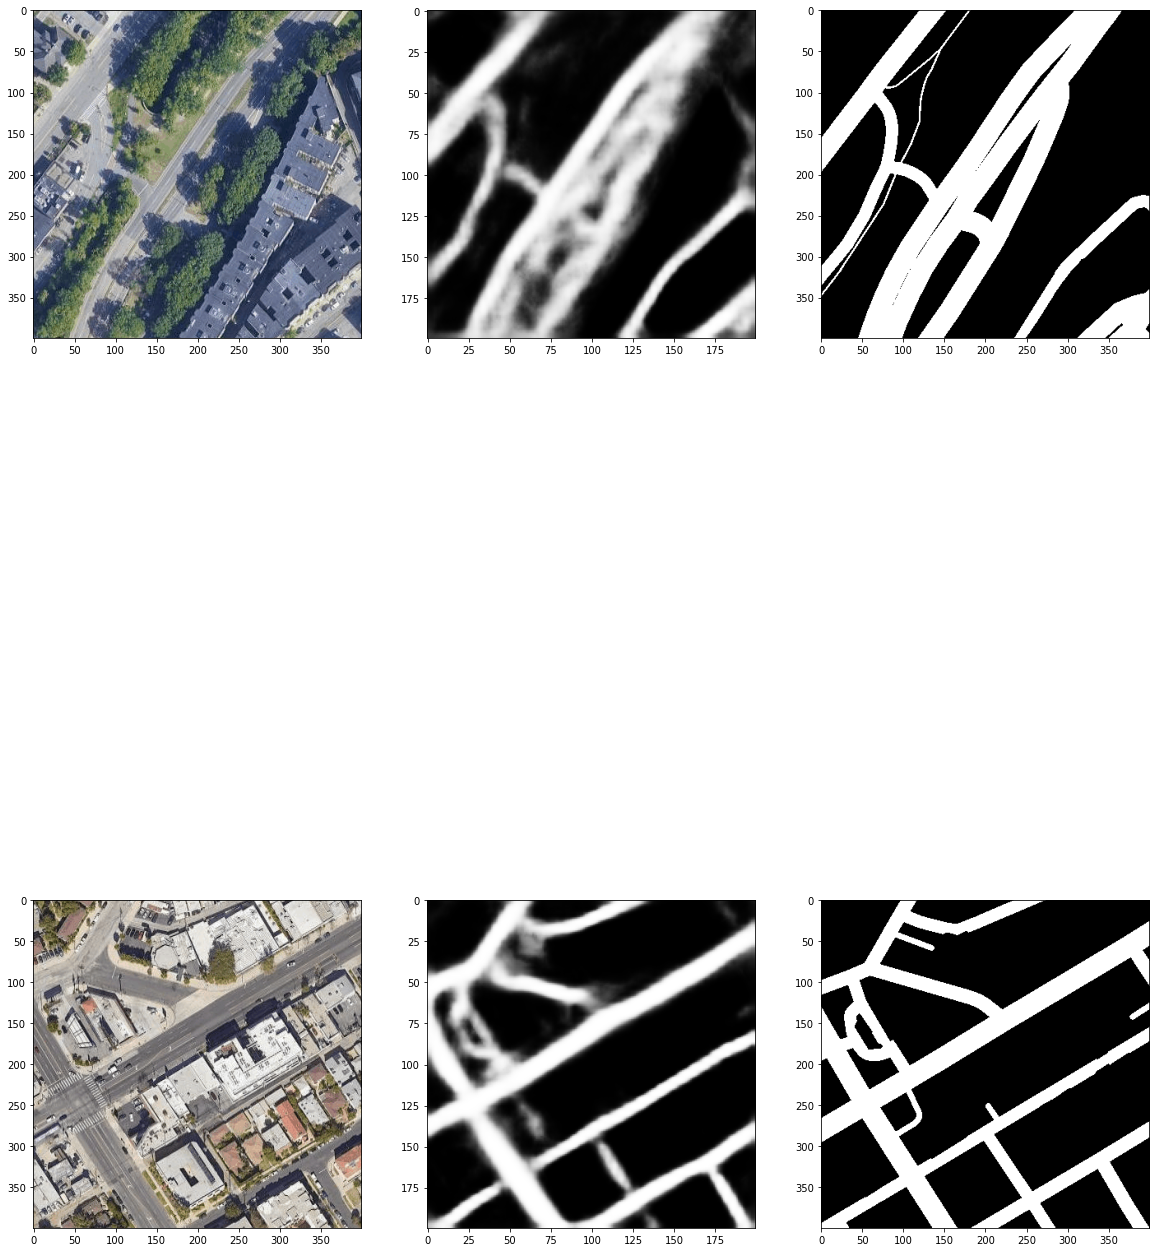

In [58]:
visualize_sample(model, val_loader)

In [ ]:
with torch.no_grad():
    test_path = main_path + "test/images/"    

    files = os.listdir(test_path)
    for file in tqdm(files):
        # print(test_path)
        # print(file)
        x_orig:Image = Image.open(test_path + file).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)/255
        x = feature_extractor(images=x_orig, return_tensors="pt").pixel_values.squeeze(0).cuda()
        pred = model(x.unsqueeze(0)).logits
        pred = torch.repeat_interleave(torch.repeat_interleave(pred, 2, dim=2), 2, dim=3)
        pred = pred.squeeze(0)
        pred = torch.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
        # print(pred.shape) # (400, 400, 1)
        pred = pred.squeeze(-1)
        # print(pred.shape) # (400, 400)
        pred = Image.fromarray((pred*255).astype(np.uint8))

        output_dir = "/kaggle/working/pred/"
        #make the folder
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        pred.save(output_dir + file)


In [ ]:
# zip the folder
import shutil
shutil.make_archive("/kaggle/working/pred", 'zip', output_dir)